# Quantum circuits and simulation of noisy algorithms

Welcome to this hands-on session. The session is build around interactive Notebooks, that include code, explanations and tasks. Please run the code cells on your computer and follow the instructions of the tasks to deepen your learning.    

Jami Rönkkö, IQM Quantum Computers, email: jami@meetiqm.com

# Transpiling circuits

In this notebook you will learn:
- to transpile circuits so that they can be executed on a given real quantum computer 
- optimise the transpilation process so that the resulting circuit would not be too long

Real quantum computers cannot execute just any quantum gate on their qubits. In practice we have to consider the **hardware restrictions** of a *Quantum Processing Unit* (QPU). Main restrictions defining a given QPU are:

1) how many qubits the QPU has
2) which qubits are connected to each other in the QPU
3) what are the native gates of the QPU

In this notebook we learn to transpile general circuits to **equivalent circuits** that match the hardware constraints of a given QPU.

## Example QPU: Helmi
Helmi, the first quantum computer of Finland was delivered by IQM to the Technical Research Centre VTT at the end of 2021. 
>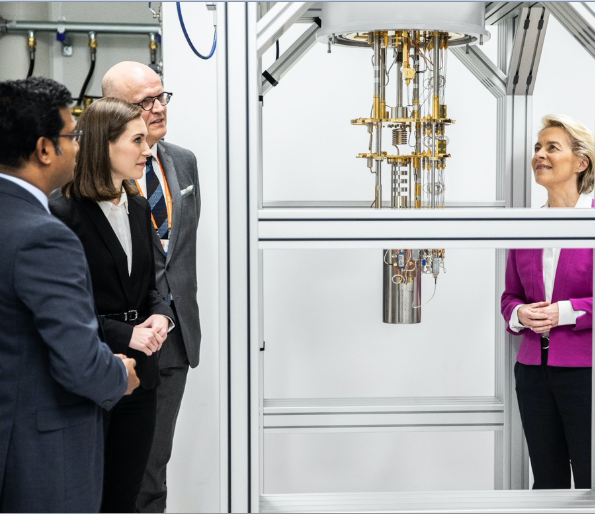
>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;    Photo: Prime Minister's Office



Helmi has five superconducting transmon qubits in a star topology:
>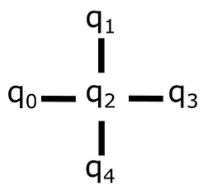

and two native gates:
>- single qubit rotation `r` with two parameters (rotation angle and axis)
>- controlled phase flip `cz`

The native single qubit gate `r` is realized by irradiating the superconducting qubit with a microwave. Amplitude and duration of the microwave signal determines the rotation angle on the Bloch sphere and the phase of the microwave defines rotation axis in the X-Y plane.

The native two qubit gate `cz` is realized by creating a conditional interaction between two neighbouring qubits. This interaction does nothing unless both qubits are 1, in which case they collect phase of $2\pi$ i.e. effectively Z gate is applied to either qubit.  


<font color='#5ACA97'><h2>TASK 1</h2></font>
> Read and run the cells below to convert default QFT circuit into Helmi compliant form.
>
> Count the number of two-qubit gates in the transpiled circuit. They are typically the leading error source in quantum computers and transpilation will often have to add more of them. 
>
> Hint: you can get the number of gates in a circuit with the method `.count_ops()`

In [ ]:
from qiskit import *
import numpy as np

We first recreate the QFT function from the previous notebook and for comparison print out the 3 qubit QFT circuit

In [ ]:
# Function that applies n qubit QFT to a circuit
def QFT(circuit, n):
    for i in range(n):
        circuit.h(i)                               # Apply Hadamard to each qubit
        for j in range(i + 1, n):               
            circuit.cp(np.pi / 2**(j-i), i, j)     # Apply controlled Phase gate with angle pi / 2^(j-i) from qubit i to all qubits with higher index j
    return circuit

In [ ]:
# Default QFT circuit for comparison
n_qubits = 3
circuit = QuantumCircuit(n_qubits)

QFT_circuit = QFT(circuit, n_qubits)

QFT_circuit.draw(output='mpl')

> Note that we defined the QFT function now so that it doesn't use barriers, since they would impede optimization of the circuit later

In `qiskit` the circuit transpilation is done simply by providing a `transpile` function with the coupling map and basis gates of a QPU:  

In [ ]:
# Define a list of coupled qubits in Helmi
coupling_map = [[0, 2], [2, 0],          # each qubit in a connected pair can be either control or target of a two-qubit gate 
                [1, 2], [2, 1],
                [3, 2], [2, 3],
                [4, 2], [2,4]]  
                 
# Define gates that the QPU can execute 
basis_gates = ['r', 'cz']

# Transpile our QFT_circuit to an equivalent circuit compliant with Helmi qubit connectivity and gate set
transpiled_circuit = transpile(QFT_circuit, basis_gates = basis_gates, coupling_map = coupling_map)

transpiled_circuit.draw(output='mpl')

Verify below that the transpiled circuit leads to the same outcome as the original QFT circuit (equal superposition).

> Note: Helmi has five qubits, but we used only three of them. Hence we should ignore the last two qubits (the two leftmost qubits in the statevector).

In [ ]:
# Let's execute the transpiled circuit to verify that the result is the equal superposition that we expect from QFT
# Execute the circuit with statevector simulator
simulator = Aer.get_backend("statevector_simulator")
result = execute(transpiled_circuit, backend = simulator).result()

state = result.get_statevector()
state.draw('latex')

## Optimization
In the last Notebook, we will see that quantum computers suffer from noise that causes errors to the state of the quantum register as time goes on. Hence, quantum circuits should be executed as fast as possible (they should not have too many gates). 

Transpiling circuits to the targeted topology and gate set in the optimal way is not a trivial task. The transpiler should produce a close to optimal circuit out of many possible equivalent circuits.

The transpiling can be roughly divided to two parts:

- **routing** = adding *SWAP gates* to bring QPU's non-connected qubits next to each other when two-qubit gate is needed between them
- **gate decomposition** = rewriting gates in terms of sequences of qpu's native gates based on various *gate identities*

Qiskit's `transpile` function can be used with varying optimization levels (0,1,2,4), that take increasingly long to run but should produce circuits with less gates. 

Roughly, the main goals of the optimization are:
* to find routing that uses as few SWAP gates as possible (each SWAP needs to be decomposed to three CNOT or CZ gates)
* to cancel as many gates as possible by placing them next to their inverse (e.g. two consecutive Hadamards or CZ's cancel)

For more information regarding the optimization methods of `transpile` see: 
https://qiskit.org/documentation/apidoc/transpiler.html

<font color='#5ACA97'><h2>TASK 2</h2></font>
> Try different optimization levels below and see how it changes the circuit depth (the number of gates on the qubit that has most gates on it) and gate counts.
>
> Note: parts of the optimization stack are stochastic, so the transpiled circuit can differ between different runs.

In [ ]:
# Create a five qubit QFT this time
n_qubits = 5
circuit = QuantumCircuit(n_qubits)

QFT_circuit = QFT(circuit, n_qubits)

# To view the circuit depth and gate count of the default QFT circuit
print('Default QFT')
print('Depth:', QFT_circuit.depth())
print('Gate counts:', QFT_circuit.count_ops())
QFT_circuit.draw(output='mpl')

QFT_circuit.draw(output='mpl')

In [ ]:
LEVEL = 0    # try different optimization levels of the transpile function

transpiled_circuit = transpile(QFT_circuit, basis_gates = basis_gates, coupling_map = coupling_map, optimization_level=LEVEL)

# View the result of transpilation
print(f'Transpiled QFT with optimization Level {LEVEL}')
print(f'Depth: {transpiled_circuit.depth()}')
print(f'Gate counts: {transpiled_circuit.count_ops()}')
 
transpiled_circuit.draw(output='mpl')

In [ ]:
# To view all results at the same time
for lvl in range(4):
   transpiled_circuit = transpile(QFT_circuit, basis_gates = basis_gates, coupling_map = coupling_map, optimization_level=lvl)
   print(f'Optimization Level {lvl}')
   print(f'Depth: {transpiled_circuit.depth()}')
   print(f'Gate counts: {transpiled_circuit.count_ops()}')
   print()

In this five qubit example optimization is fast for all levels, but with more qubits and longer circuits one might need to consider how long they can wait.

## Takeaway

- Quantum computers are typically designed to implement only few different gates on the hardware level; e.g. R($\theta$,$\phi$) and CZ

- Quantum circuits for algorithms are often expressed with different gates; e.g. X, H, CNOT, P($\phi$)

- QPU's are often limited to some kind of nearest neighbor connectivity between it's qubits, whereas algorithms usually assume all-to-all connectivity
 
- Thus one has to transpile circuit to an equivalent hardware compliant form (using SWAP gates and gate decomposition identities)

- Doing the transpilation in an optimal way regarding the gate count is important when considering noise and errors affecting real QPUs

In the next notebook we consider another algorithm called Quantum Phase Estimation. Later we will use this algorithm to study effects of noise to a quantum algorithms.